Importing the required Libraries

In [0]:
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
from sklearn.preprocessing import (
    StandardScaler,
    LabelEncoder
)
from sklearn.metrics import (
    auc,
    roc_auc_score,
    roc_curve,
    accuracy_score,
    precision_score,
    average_precision_score,
    recall_score,
    f1_score,
    precision_recall_curve,
    confusion_matrix
)
from sklearn.model_selection import (
    train_test_split,
    StratifiedKFold,
    cross_val_score,
)
import seaborn as sns
from sklearn import (
    ensemble,
    model_selection,
    preprocessing,
    tree
)


Importing the data

In [2]:
from google.colab import files
uploaded = files.upload()

Saving 00.1_Original-Dataset.csv to 00.1_Original-Dataset (1).csv


Reading the data

In [3]:
df = pd.read_csv(r"00.1_Original-Dataset.csv")
df.head(10)

,customerID,gender,SeniorCitizen,Partner,Dependents,tenure,PhoneService,MultipleLines,InternetService,OnlineSecurity,OnlineBackup,DeviceProtection,TechSupport,StreamingTV,StreamingMovies,Contract,PaperlessBilling,PaymentMethod,MonthlyCharges,TotalCharges,Churn
0,7590-VHVEG,Female,0,Yes,No,1,No,No phone service,DSL,No,Yes,No,No,No,No,Month-to-month,Yes,Electronic check,29.85,29.85,No
1,5575-GNVDE,Male,0,No,No,34,Yes,No,DSL,Yes,No,Yes,No,No,No,One year,No,Mailed check,56.95,1889.5,No
2,3668-QPYBK,Male,0,No,No,2,Yes,No,DSL,Yes,Yes,No,No,No,No,Month-to-month,Yes,Mailed check,53.85,108.15,Yes
3,7795-CFOCW,Male,0,No,No,45,No,No phone service,DSL,Yes,No,Yes,Yes,No,No,One year,No,Bank transfer (automatic),42.30,1840.75,No
4,9237-HQITU,Female,0,No,No,2,Yes,No,Fiber optic,No,No,No,No,No,No,Month-to-month,Yes,Electronic check,70.70,151.65,Yes
5,9305-CDSKC,Female,0,No,No,8,Yes,Yes,Fiber optic,No,No,Yes,No,Yes,Yes,Month-to-month,Yes,Electronic check,99.65,820.5,Yes
6,1452-KIOVK,Male,0,No,Yes,22,Yes,Yes,Fiber optic,No,Yes,No,No,Yes,No,Month-to-month,Yes,Credit card (automatic),89.10,1949.4,No
7,6713-OKOMC,Female,0,No,No,10,No,No phone service,DSL,Yes,No,No,No,No,No,Month-to-month,No,Mailed check,29.75,301.9,No
8,7892-POOKP,Female,0,Yes,No,28,Yes,Yes,Fiber optic,No,No,Yes,Yes,Yes,Yes,Month-to-month,Yes,Electronic check,104.80,3046.05,Yes
9,6388-TABGU,Male,0,No,Yes,62,Yes,No,DSL,Yes,Yes,No,No,No,No,One year,No,Bank transfer (automatic),56.15,3487.95,No


Checking the data types of features

In [4]:
df.dtypes


customerID           object
gender               object
SeniorCitizen         int64
Partner              object
Dependents           object
tenure                int64
PhoneService         object
MultipleLines        object
InternetService      object
OnlineSecurity       object
OnlineBackup         object
DeviceProtection     object
TechSupport          object
StreamingTV          object
StreamingMovies      object
Contract             object
PaperlessBilling     object
PaymentMethod        object
MonthlyCharges      float64
TotalCharges         object
Churn                object
dtype: object

Dropping ID column

In [0]:

df.drop(['customerID'],
        axis=1,
        inplace=True)


Text(0, 0.5, 'Data type')

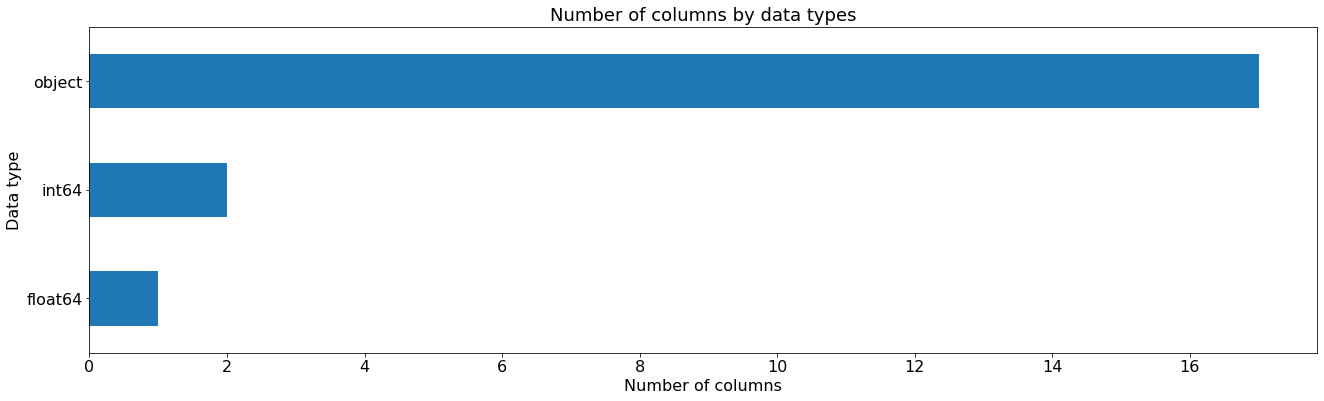

In [6]:
df.dtypes.value_counts().sort_values().plot(kind='barh',
                                            figsize=(22, 6),
                                            fontsize=16)

plt.title('Number of columns by data types', fontsize=18)
plt.xlabel('Number of columns', fontsize=16)
plt.ylabel('Data type', fontsize=16)


####A lot of Categorical variables, let's look how many outcomes are possible for each categorical variable


In [7]:
nunique_df = pd.DataFrame(df.select_dtypes('object').apply(pd.Series.nunique, axis=0), columns=['Variants'])
nunique_df = nunique_df.reset_index()
nunique_df.columns = ['Column Name', 'Variants']
nunique_df


,Column Name,Variants
0,gender,2
1,Partner,2
2,Dependents,2
3,PhoneService,2
4,MultipleLines,3
5,InternetService,3
6,OnlineSecurity,3
7,OnlineBackup,3
8,DeviceProtection,3
9,TechSupport,3


The data type for TotalCharges is Object, this should be typecasted to float. The missing values are replaced by 0

In [8]:
print("The missing values in TotalCharges are : ", 100*len(df[df.TotalCharges==' '])/len(df),'%')

The missing values in TotalCharges are :  0.15618344455487718 %


In [9]:
for i in range(len(df)):
    if df.TotalCharges.iloc[i] != ' ':
         df.TotalCharges.iloc[i] = float(df.TotalCharges.iloc[i])
    else:
        df.TotalCharges.iloc[i] = 0

df = df.astype({'TotalCharges': 'float'})

/usr/local/lib/python3.6/dist-packages/pandas/core/indexing.py:205: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  self._setitem_with_indexer(indexer, value)


Checking for missing values in columns other than TotalCharges since that column is already dealt with

In [10]:

def missing_values(df):
    mis_val = df.isnull().sum()
    mis_val_percent = 100 * df.isnull().sum() / len(df)
    mis_val_table = pd.concat([mis_val, mis_val_percent], axis=1)
    mis_val_table_ren_columns = mis_val_table.rename(columns={
        0: 'Missing Values',
        1: '% of Total Values'
    })
    mis_val_table_ren_columns = mis_val_table_ren_columns[
        mis_val_table_ren_columns.iloc[:, 1] != 0].sort_values(
            '% of Total Values', ascending=False).round(1)
    print("Dataframe has " + str(df.shape[1]) + " columns.")
    print("There are " + str(mis_val_table_ren_columns.shape[0]) +
          " columns that have missing values.")
    
    return mis_val_table_ren_columns

# Missing values statistics
miss_values = missing_values(df)
miss_values.head(20)


Dataframe has 20 columns.
There are 0 columns that have missing values.


,Missing Values,% of Total Values


No missing Value

Creating a target variable

In [11]:
df['Churn'].unique()

target = [ 1 if i == 'Yes' else 0 for i in df['Churn']]

df['target'] = target
df['target'].value_counts()

0    5174
1    1869
Name: target, dtype: int64

We notice that 0 is much more common of an outcome than 1

In [0]:
df.drop('Churn', axis=1, inplace=True)


In [13]:
df.head(5)

,gender,SeniorCitizen,Partner,Dependents,tenure,PhoneService,MultipleLines,InternetService,OnlineSecurity,OnlineBackup,DeviceProtection,TechSupport,StreamingTV,StreamingMovies,Contract,PaperlessBilling,PaymentMethod,MonthlyCharges,TotalCharges,target
0,Female,0,Yes,No,1,No,No phone service,DSL,No,Yes,No,No,No,No,Month-to-month,Yes,Electronic check,29.85,29.85,0
1,Male,0,No,No,34,Yes,No,DSL,Yes,No,Yes,No,No,No,One year,No,Mailed check,56.95,1889.50,0
2,Male,0,No,No,2,Yes,No,DSL,Yes,Yes,No,No,No,No,Month-to-month,Yes,Mailed check,53.85,108.15,1
3,Male,0,No,No,45,No,No phone service,DSL,Yes,No,Yes,Yes,No,No,One year,No,Bank transfer (automatic),42.30,1840.75,0
4,Female,0,No,No,2,Yes,No,Fiber optic,No,No,No,No,No,No,Month-to-month,Yes,Electronic check,70.70,151.65,1


#### Encoding and Dummifying

In [0]:

class MultiColumnLabelEncoder:
    def __init__(self,columns = None):
        self.columns = columns # array of column names to encode

    def fit(self,X,y=None):
        return self # not relevant here

    def transform(self,X):
        '''
        Transforms columns of X specified in self.columns using
        LabelEncoder(). If no columns specified, transforms all
        columns in X.
        '''
        output = X.copy()
        if self.columns is not None:
            for col in self.columns:
                output[col] = LabelEncoder().fit_transform(output[col])
        else:
            for colname,col in output.iteritems():
                output[colname] = LabelEncoder().fit_transform(col)
        return output

    def fit_transform(self,X,y=None):
        return self.fit(X,y).transform(X)

In [15]:
df.columns

Index(['gender', 'SeniorCitizen', 'Partner', 'Dependents', 'tenure',
       'PhoneService', 'MultipleLines', 'InternetService', 'OnlineSecurity',
       'OnlineBackup', 'DeviceProtection', 'TechSupport', 'StreamingTV',
       'StreamingMovies', 'Contract', 'PaperlessBilling', 'PaymentMethod',
       'MonthlyCharges', 'TotalCharges', 'target'],
      dtype='object')

In [16]:
binary = ['gender', 'Partner', 'Dependents', 'PhoneService', 'PaperlessBilling']
df = MultiColumnLabelEncoder(columns = binary).fit_transform(df)
df.head()

,gender,SeniorCitizen,Partner,Dependents,tenure,PhoneService,MultipleLines,InternetService,OnlineSecurity,OnlineBackup,DeviceProtection,TechSupport,StreamingTV,StreamingMovies,Contract,PaperlessBilling,PaymentMethod,MonthlyCharges,TotalCharges,target
0,0,0,1,0,1,0,No phone service,DSL,No,Yes,No,No,No,No,Month-to-month,1,Electronic check,29.85,29.85,0
1,1,0,0,0,34,1,No,DSL,Yes,No,Yes,No,No,No,One year,0,Mailed check,56.95,1889.50,0
2,1,0,0,0,2,1,No,DSL,Yes,Yes,No,No,No,No,Month-to-month,1,Mailed check,53.85,108.15,1
3,1,0,0,0,45,0,No phone service,DSL,Yes,No,Yes,Yes,No,No,One year,0,Bank transfer (automatic),42.30,1840.75,0
4,0,0,0,0,2,1,No,Fiber optic,No,No,No,No,No,No,Month-to-month,1,Electronic check,70.70,151.65,1


In [0]:
categorical = ['MultipleLines', 'InternetService', 'OnlineSecurity',
       'OnlineBackup', 'DeviceProtection', 'TechSupport', 'StreamingTV',
       'StreamingMovies', 'Contract', 'PaymentMethod']
df = pd.get_dummies(df, columns = categorical)


In [18]:
df.head()

,gender,SeniorCitizen,Partner,Dependents,tenure,PhoneService,PaperlessBilling,MonthlyCharges,TotalCharges,target,MultipleLines_No,MultipleLines_No phone service,MultipleLines_Yes,InternetService_DSL,InternetService_Fiber optic,InternetService_No,OnlineSecurity_No,OnlineSecurity_No internet service,OnlineSecurity_Yes,OnlineBackup_No,OnlineBackup_No internet service,OnlineBackup_Yes,DeviceProtection_No,DeviceProtection_No internet service,DeviceProtection_Yes,TechSupport_No,TechSupport_No internet service,TechSupport_Yes,StreamingTV_No,StreamingTV_No internet service,StreamingTV_Yes,StreamingMovies_No,StreamingMovies_No internet service,StreamingMovies_Yes,Contract_Month-to-month,Contract_One year,Contract_Two year,PaymentMethod_Bank transfer (automatic),PaymentMethod_Credit card (automatic),PaymentMethod_Electronic check,PaymentMethod_Mailed check
0,0,0,1,0,1,0,1,29.85,29.85,0,0,1,0,1,0,0,1,0,0,0,0,1,1,0,0,1,0,0,1,0,0,1,0,0,1,0,0,0,0,1,0
1,1,0,0,0,34,1,0,56.95,1889.50,0,1,0,0,1,0,0,0,0,1,1,0,0,0,0,1,1,0,0,1,0,0,1,0,0,0,1,0,0,0,0,1
2,1,0,0,0,2,1,1,53.85,108.15,1,1,0,0,1,0,0,0,0,1,0,0,1,1,0,0,1,0,0,1,0,0,1,0,0,1,0,0,0,0,0,1
3,1,0,0,0,45,0,0,42.30,1840.75,0,0,1,0,1,0,0,0,0,1,1,0,0,0,0,1,0,0,1,1,0,0,1,0,0,0,1,0,1,0,0,0
4,0,0,0,0,2,1,1,70.70,151.65,1,1,0,0,0,1,0,1,0,0,1,0,0,1,0,0,1,0,0,1,0,0,1,0,0,1,0,0,0,0,1,0


Checking correlation between variables

In [19]:

corr = df.corr()['target'].sort_values()

# Display correlations
print('Top 10 - Positive Correlations:')
print('-----------------------------------')
print(corr.tail(10))
print('\nTop 10 - Negative Correlations:')
print('------------------------------')
print(corr.head(10))


Top 10 - Positive Correlations:
-----------------------------------
PaperlessBilling                  0.191825
MonthlyCharges                    0.193356
DeviceProtection_No               0.252481
OnlineBackup_No                   0.268005
PaymentMethod_Electronic check    0.301919
InternetService_Fiber optic       0.308020
TechSupport_No                    0.337281
OnlineSecurity_No                 0.342637
Contract_Month-to-month           0.405103
target                            1.000000
Name: target, dtype: float64

Top 10 - Negative Correlations:
------------------------------
tenure                                 -0.352229
Contract_Two year                      -0.302253
OnlineBackup_No internet service       -0.227890
InternetService_No                     -0.227890
DeviceProtection_No internet service   -0.227890
TechSupport_No internet service        -0.227890
StreamingTV_No internet service        -0.227890
StreamingMovies_No internet service    -0.227890
OnlineSecurity_No

####Visualising the Correaltion

[Text(0.5, 0, 'gender'),
 Text(1.5, 0, 'SeniorCitizen'),
 Text(2.5, 0, 'Partner'),
 Text(3.5, 0, 'Dependents'),
 Text(4.5, 0, 'tenure'),
 Text(5.5, 0, 'PhoneService'),
 Text(6.5, 0, 'PaperlessBilling'),
 Text(7.5, 0, 'MonthlyCharges'),
 Text(8.5, 0, 'TotalCharges'),
 Text(9.5, 0, 'target'),
 Text(10.5, 0, 'MultipleLines_No'),
 Text(11.5, 0, 'MultipleLines_No phone service'),
 Text(12.5, 0, 'MultipleLines_Yes'),
 Text(13.5, 0, 'InternetService_DSL'),
 Text(14.5, 0, 'InternetService_Fiber optic'),
 Text(15.5, 0, 'InternetService_No'),
 Text(16.5, 0, 'OnlineSecurity_No'),
 Text(17.5, 0, 'OnlineSecurity_No internet service'),
 Text(18.5, 0, 'OnlineSecurity_Yes'),
 Text(19.5, 0, 'OnlineBackup_No'),
 Text(20.5, 0, 'OnlineBackup_No internet service'),
 Text(21.5, 0, 'OnlineBackup_Yes'),
 Text(22.5, 0, 'DeviceProtection_No'),
 Text(23.5, 0, 'DeviceProtection_No internet service'),
 Text(24.5, 0, 'DeviceProtection_Yes'),
 Text(25.5, 0, 'TechSupport_No'),
 Text(26.5, 0, 'TechSupport_No internet 

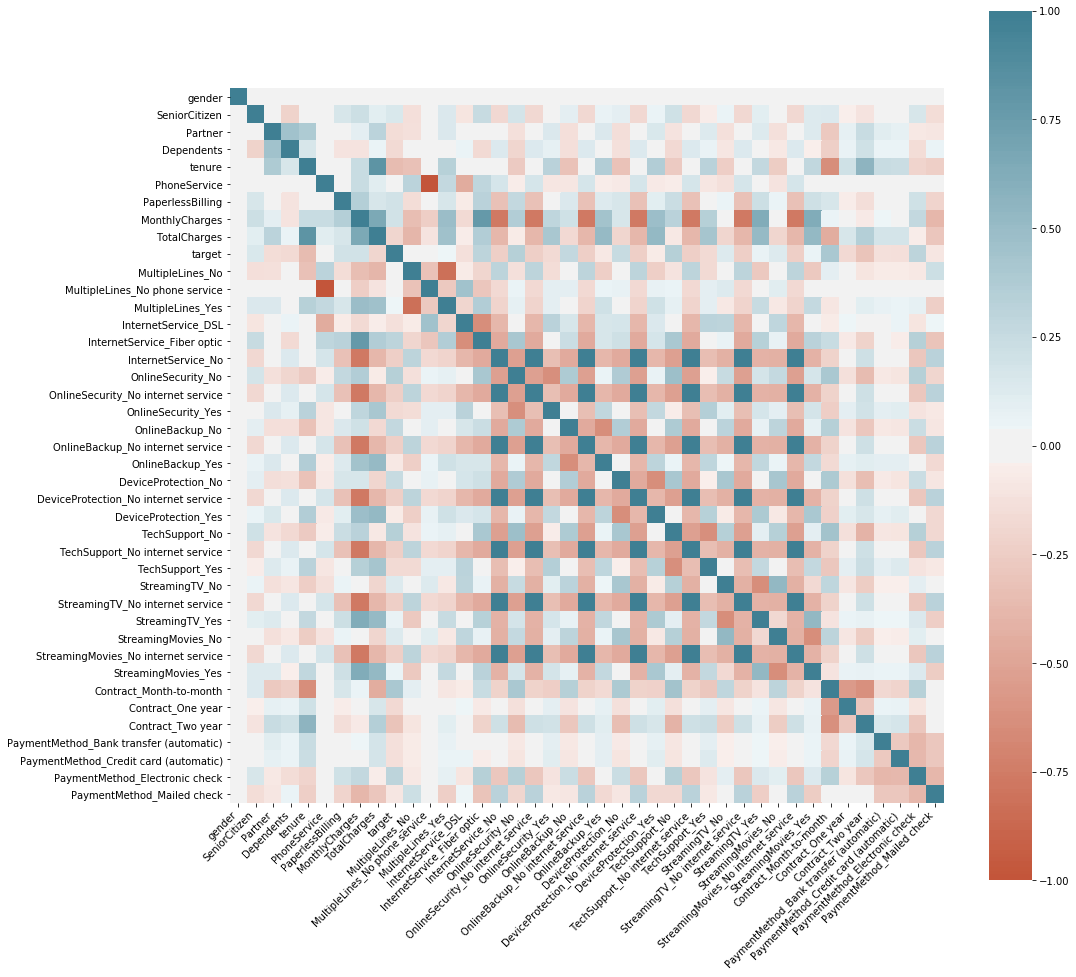

In [20]:

correlation = df.corr()
plt.figure(figsize=(16, 16))
ax = sns.heatmap(
    correlation, 
    vmin=-1, vmax=1, center=0,
    cmap=sns.diverging_palette(20, 220, n=200),
    square=True
)
ax.set_xticklabels(
    ax.get_xticklabels(),
    rotation=45,
    horizontalalignment='right'
)

 

In [21]:
df[df.target==1].describe()

,gender,SeniorCitizen,Partner,Dependents,tenure,PhoneService,PaperlessBilling,MonthlyCharges,TotalCharges,target,MultipleLines_No,MultipleLines_No phone service,MultipleLines_Yes,InternetService_DSL,InternetService_Fiber optic,InternetService_No,OnlineSecurity_No,OnlineSecurity_No internet service,OnlineSecurity_Yes,OnlineBackup_No,OnlineBackup_No internet service,OnlineBackup_Yes,DeviceProtection_No,DeviceProtection_No internet service,DeviceProtection_Yes,TechSupport_No,TechSupport_No internet service,TechSupport_Yes,StreamingTV_No,StreamingTV_No internet service,StreamingTV_Yes,StreamingMovies_No,StreamingMovies_No internet service,StreamingMovies_Yes,Contract_Month-to-month,Contract_One year,Contract_Two year,PaymentMethod_Bank transfer (automatic),PaymentMethod_Credit card (automatic),PaymentMethod_Electronic check,PaymentMethod_Mailed check
count,1869.000000,1869.000000,1869.000000,1869.000000,1869.000000,1869.000000,1869.000000,1869.000000,1869.000000,1869.0,1869.000000,1869.000000,1869.000000,1869.000000,1869.000000,1869.000000,1869.000000,1869.000000,1869.000000,1869.000000,1869.000000,1869.000000,1869.00000,1869.000000,1869.000000,1869.000000,1869.000000,1869.000000,1869.000000,1869.000000,1869.000000,1869.000000,1869.000000,1869.000000,1869.000000,1869.000000,1869.000000,1869.000000,1869.000000,1869.000000,1869.000000
mean,0.497592,0.254682,0.357945,0.174425,17.979133,0.909042,0.749064,74.441332,1531.796094,1.0,0.454254,0.090958,0.454789,0.245586,0.693954,0.060460,0.781701,0.060460,0.157838,0.659711,0.060460,0.279829,0.64794,0.060460,0.291600,0.773676,0.060460,0.165864,0.504013,0.060460,0.435527,0.501873,0.060460,0.437667,0.885500,0.088818,0.025682,0.138042,0.124131,0.573034,0.164794
std,0.500128,0.435799,0.479524,0.379576,19.531123,0.287626,0.433668,24.666053,1890.822994,0.0,0.498036,0.287626,0.498085,0.430549,0.460972,0.238401,0.413202,0.238401,0.364687,0.473933,0.238401,0.449035,0.47774,0.238401,0.454621,0.418563,0.238401,0.372058,0.500118,0.238401,0.495959,0.500130,0.238401,0.496232,0.318502,0.284556,0.158228,0.345036,0.329819,0.494770,0.371094
min,0.000000,0.000000,0.000000,0.000000,1.000000,0.000000,0.000000,18.850000,18.850000,1.0,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.00000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000
25%,0.000000,0.000000,0.000000,0.000000,2.000000,1.000000,0.000000,56.150000,134.500000,1.0,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,1.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.00000,0.000000,0.000000,1.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,1.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000
50%,0.000000,0.000000,0.000000,0.000000,10.000000,1.000000,1.000000,79.650000,703.550000,1.0,0.000000,0.000000,0.000000,0.000000,1.000000,0.000000,1.000000,0.000000,0.000000,1.000000,0.000000,0.000000,1.00000,0.000000,0.000000,1.000000,0.000000,0.000000,1.000000,0.000000,0.000000,1.000000,0.000000,0.000000,1.000000,0.000000,0.000000,0.000000,0.000000,1.000000,0.000000
75%,1.000000,1.000000,1.000000,0.000000,29.000000,1.000000,1.000000,94.200000,2331.300000,1.0,1.000000,0.000000,1.000000,0.000000,1.000000,0.000000,1.000000,0.000000,0.000000,1.000000,0.000000,1.000000,1.00000,0.000000,1.000000,1.000000,0.000000,0.000000,1.000000,0.000000,1.000000,1.000000,0.000000,1.000000,1.000000,0.000000,0.000000,0.000000,0.000000,1.000000,0.000000
max,1.000000,1.000000,1.000000,1.000000,72.000000,1.000000,1.000000,118.350000,8684.800000,1.0,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.00000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000


In [22]:
df[df.target==0].describe()

,gender,SeniorCitizen,Partner,Dependents,tenure,PhoneService,PaperlessBilling,MonthlyCharges,TotalCharges,target,MultipleLines_No,MultipleLines_No phone service,MultipleLines_Yes,InternetService_DSL,InternetService_Fiber optic,InternetService_No,OnlineSecurity_No,OnlineSecurity_No internet service,OnlineSecurity_Yes,OnlineBackup_No,OnlineBackup_No internet service,OnlineBackup_Yes,DeviceProtection_No,DeviceProtection_No internet service,DeviceProtection_Yes,TechSupport_No,TechSupport_No internet service,TechSupport_Yes,StreamingTV_No,StreamingTV_No internet service,StreamingTV_Yes,StreamingMovies_No,StreamingMovies_No internet service,StreamingMovies_Yes,Contract_Month-to-month,Contract_One year,Contract_Two year,PaymentMethod_Bank transfer (automatic),PaymentMethod_Credit card (automatic),PaymentMethod_Electronic check,PaymentMethod_Mailed check
count,5174.000000,5174.000000,5174.000000,5174.000000,5174.000000,5174.000000,5174.000000,5174.000000,5174.000000,5174.0,5174.000000,5174.000000,5174.000000,5174.000000,5174.000000,5174.000000,5174.000000,5174.000000,5174.000000,5174.000000,5174.000000,5174.000000,5174.000000,5174.000000,5174.000000,5174.000000,5174.000000,5174.000000,5174.000000,5174.000000,5174.000000,5174.000000,5174.000000,5174.000000,5174.000000,5174.000000,5174.000000,5174.000000,5174.000000,5174.000000,5174.000000
mean,0.507344,0.128721,0.528218,0.344801,37.569965,0.901044,0.535562,61.265124,2549.911442,0.0,0.491109,0.098956,0.409934,0.379204,0.347700,0.273096,0.393699,0.273096,0.333204,0.358523,0.273096,0.368380,0.364128,0.273096,0.362775,0.391767,0.273096,0.335137,0.361036,0.273096,0.365868,0.356977,0.273096,0.369927,0.429068,0.252609,0.318322,0.248550,0.249324,0.250097,0.252029
std,0.499994,0.334923,0.499251,0.475349,24.113777,0.298632,0.498782,31.092648,2329.954215,0.0,0.499969,0.298632,0.491869,0.485236,0.476286,0.445593,0.488617,0.445593,0.471405,0.479613,0.445593,0.482412,0.481231,0.445593,0.480847,0.488192,0.445593,0.472084,0.480347,0.445593,0.481719,0.479154,0.445593,0.482831,0.494991,0.434551,0.465870,0.432214,0.432663,0.433110,0.434220
min,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,18.250000,0.000000,0.0,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000
25%,0.000000,0.000000,0.000000,0.000000,15.000000,1.000000,0.000000,25.100000,572.900000,0.0,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000
50%,1.000000,0.000000,1.000000,0.000000,38.000000,1.000000,1.000000,64.425000,1679.525000,0.0,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000
75%,1.000000,0.000000,1.000000,1.000000,61.000000,1.000000,1.000000,88.400000,4262.850000,0.0,1.000000,0.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,0.000000,0.000000,0.750000,1.000000
max,1.000000,1.000000,1.000000,1.000000,72.000000,1.000000,1.000000,118.750000,8672.450000,0.0,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000


In [23]:
df.columns

Index(['gender', 'SeniorCitizen', 'Partner', 'Dependents', 'tenure',
       'PhoneService', 'PaperlessBilling', 'MonthlyCharges', 'TotalCharges',
       'target', 'MultipleLines_No', 'MultipleLines_No phone service',
       'MultipleLines_Yes', 'InternetService_DSL',
       'InternetService_Fiber optic', 'InternetService_No',
       'OnlineSecurity_No', 'OnlineSecurity_No internet service',
       'OnlineSecurity_Yes', 'OnlineBackup_No',
       'OnlineBackup_No internet service', 'OnlineBackup_Yes',
       'DeviceProtection_No', 'DeviceProtection_No internet service',
       'DeviceProtection_Yes', 'TechSupport_No',
       'TechSupport_No internet service', 'TechSupport_Yes', 'StreamingTV_No',
       'StreamingTV_No internet service', 'StreamingTV_Yes',
       'StreamingMovies_No', 'StreamingMovies_No internet service',
       'StreamingMovies_Yes', 'Contract_Month-to-month', 'Contract_One year',
       'Contract_Two year', 'PaymentMethod_Bank transfer (automatic)',
       'PaymentMeth

Making feature vectors and target variable

In [0]:
y = df.target
X = df.drop(['target'], axis = 1)

In [25]:
X.shape

(7043, 40)

In [0]:
df.to_excel('no_removal_preprocessed_data.xlsx')